# DYNAMIC PRICING ENGINE - JETTO.ID
## Data Modelling


### library


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [5]:

np.random.seed(42)

print("="*60)
print("DYNAMIC PRICING ENGINE - JETTO.ID")
print("Fase 2: Modeling & Hyperparameter Tuning")
print("="*60)


DYNAMIC PRICING ENGINE - JETTO.ID
Fase 2: Modeling & Hyperparameter Tuning


### Load data

In [6]:


print("\n" + "="*60)
print("1. MEMUAT DATA (DATA LOADING)")
print("="*60)

abt = pd.read_csv('04_analytics_base_table.csv')
print(f"✓ Berhasil memuat Analytics Base Table: {abt.shape}")

df_jetto = pd.read_csv('03_jetto_simulated_transactions.csv')
print(f"✓ Berhasil memuat Transaksi Jetto: {df_jetto.shape}")

print(f"\nKolom ABT:")
print(abt.columns.tolist())


1. MEMUAT DATA (DATA LOADING)
✓ Berhasil memuat Analytics Base Table: (497, 24)
✓ Berhasil memuat Transaksi Jetto: (50000, 19)

Kolom ABT:
['product_id', 'market_price_mean', 'market_price_std', 'market_price_min', 'market_price_max', 'jetto_price_mean', 'jetto_price_std', 'jetto_price_min', 'jetto_price_max', 'total_quantity_sold', 'avg_quantity_sold', 'std_quantity_sold', 'total_revenue', 'avg_revenue', 'std_revenue', 'transaction_count', 'weekend_ratio', 'peak_hour_ratio', 'price_elasticity', 'category', 'product_name', 'price_discount_avg', 'revenue_per_transaction', 'price_volatility']


### Feature engineering


In [7]:

print(f"\n{'='*60}")
print("2. FEATURE ENGINEERING UNTUK MODELING")
print("="*60)

target = 'jetto_price_mean'

transaction_features = df_jetto.groupby('product_id').agg({
    'season': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'normal',
    'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Monday',
    'profit_margin_pct': 'mean',
    'stock_level': 'mean'
}).reset_index()

transaction_features.columns = ['product_id', 'dominant_season', 'dominant_day', 
                                 'avg_profit_margin', 'avg_stock_level']

abt_full = abt.merge(transaction_features, on='product_id', how='left')

print(f"✓ Shape ABT setelah diperkaya: {abt_full.shape}")



2. FEATURE ENGINEERING UNTUK MODELING
✓ Shape ABT setelah diperkaya: (497, 28)


### feature selection & preprocessing, encoders 

In [8]:


print(f"\n{'='*60}")
print("3. SELEKSI FITUR & PREPROCESSING")
print("="*60)

numeric_features = [
    'market_price_mean', 'market_price_std', 'market_price_min', 'market_price_max',
    'total_quantity_sold', 'avg_quantity_sold', 'std_quantity_sold',
    'total_revenue', 'avg_revenue', 'std_revenue',
    'transaction_count', 'weekend_ratio', 'peak_hour_ratio',
    'price_elasticity', 'revenue_per_transaction', 'price_volatility',
    'avg_profit_margin', 'avg_stock_level'
]

categorical_features = ['category', 'dominant_season', 'dominant_day']

abt_full[numeric_features] = abt_full[numeric_features].fillna(abt_full[numeric_features].median())
abt_full[categorical_features] = abt_full[categorical_features].fillna('unknown')

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    abt_full[f'{col}_encoded'] = le.fit_transform(abt_full[col].astype(str))
    label_encoders[col] = le

encoded_features = [f'{col}_encoded' for col in categorical_features]

feature_columns = numeric_features + encoded_features
X = abt_full[feature_columns]
y = abt_full[target]

print(f"\n✓ Shape Matriks Fitur: {X.shape}")
print(f"✓ Variabel Target: {target}")
print(f"✓ Statistik Target:")
print(y.describe())

if X.isnull().sum().sum() > 0:
    print(f"\n⚠ Peringatan: Ditemukan {X.isnull().sum().sum()} missing values. Mengisi dengan median...")
    X = X.fillna(X.median())



3. SELEKSI FITUR & PREPROCESSING

✓ Shape Matriks Fitur: (497, 21)
✓ Variabel Target: jetto_price_mean
✓ Statistik Target:
count    497.000000
mean       3.173083
std        2.426667
min        0.411633
25%        1.552250
50%        2.343118
75%        4.146813
max       13.080111
Name: jetto_price_mean, dtype: float64



### train test-splitting

In [9]:

print(f"\n{'='*60}")
print("4. TRAIN-TEST SPLIT")
print("="*60)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"✓ Training Set: {X_train.shape[0]} sampel ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✓ Validation Set: {X_val.shape[0]} sampel ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"✓ Test Set: {X_test.shape[0]} sampel ({X_test.shape[0]/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Scaling fitur selesai")



4. TRAIN-TEST SPLIT
✓ Training Set: 347 sampel (69.8%)
✓ Validation Set: 75 sampel (15.1%)
✓ Test Set: 75 sampel (15.1%)

✓ Scaling fitur selesai



### baseline models (regression)

In [10]:

print(f"\n{'='*60}")
print("5. BASELINE MODELS")
print("="*60)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_mape = np.mean(np.abs((y_train - y_train_pred) / (y_train + 1e-10))) * 100
    val_mape = np.mean(np.abs((y_val - y_val_pred) / (y_val + 1e-10))) * 100
    
    results = {
        'Model': model_name,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Train_MAE': train_mae,
        'Val_MAE': val_mae,
        'Train_MAPE': train_mape,
        'Val_MAPE': val_mape
    }
    
    return results, model

model_results = []

print("\n5.1 LINEAR REGRESSION")
print("-" * 60)
lr_results, lr_model = evaluate_model(
    LinearRegression(), X_train_scaled, y_train, X_val_scaled, y_val, 
    "Linear Regression"
)
model_results.append(lr_results)
print(f"✓ Train R²: {lr_results['Train_R2']:.4f} | Val R²: {lr_results['Val_R2']:.4f}")
print(f"  Train RMSE: {lr_results['Train_RMSE']:.4f} | Val RMSE: {lr_results['Val_RMSE']:.4f}")

print("\n5.2 RIDGE REGRESSION")
print("-" * 60)
ridge_results, ridge_model = evaluate_model(
    Ridge(alpha=1.0, random_state=42), X_train_scaled, y_train, X_val_scaled, y_val,
    "Ridge Regression"
)
model_results.append(ridge_results)
print(f"✓ Train R²: {ridge_results['Train_R2']:.4f} | Val R²: {ridge_results['Val_R2']:.4f}")

print("\n5.3 LASSO REGRESSION")
print("-" * 60)
lasso_results, lasso_model = evaluate_model(
    Lasso(alpha=0.1, random_state=42), X_train_scaled, y_train, X_val_scaled, y_val,
    "Lasso Regression"
)
model_results.append(lasso_results)
print(f"✓ Train R²: {lasso_results['Train_R2']:.4f} | Val R²: {lasso_results['Val_R2']:.4f}")

print("\n5.4 ELASTIC NET")
print("-" * 60)
elasticnet_results, elasticnet_model = evaluate_model(
    ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42), 
    X_train_scaled, y_train, X_val_scaled, y_val,
    "Elastic Net"
)
model_results.append(elasticnet_results)
print(f"✓ Train R²: {elasticnet_results['Train_R2']:.4f} | Val R²: {elasticnet_results['Val_R2']:.4f}")



5. BASELINE MODELS

5.1 LINEAR REGRESSION
------------------------------------------------------------
✓ Train R²: 1.0000 | Val R²: 1.0000
  Train RMSE: 0.0108 | Val RMSE: 0.0158

5.2 RIDGE REGRESSION
------------------------------------------------------------
✓ Train R²: 0.9997 | Val R²: 0.9994

5.3 LASSO REGRESSION
------------------------------------------------------------
✓ Train R²: 0.9982 | Val R²: 0.9983

5.4 ELASTIC NET
------------------------------------------------------------
✓ Train R²: 0.9980 | Val R²: 0.9976


### advanced models (rf, gradient boosting, xgboost)

In [11]:

print(f"\n{'='*60}")
print("6. ADVANCED MODELS")
print("="*60)

print("\n6.1 RANDOM FOREST")
print("-" * 60)
rf_results, rf_model = evaluate_model(
    RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5,
                         min_samples_leaf=2, random_state=42, n_jobs=-1),
    X_train, y_train, X_val, y_val,
    "Random Forest"
)
model_results.append(rf_results)
print(f"✓ Train R²: {rf_results['Train_R2']:.4f} | Val R²: {rf_results['Val_R2']:.4f}")

print("\n6.2 GRADIENT BOOSTING")
print("-" * 60)
gb_results, gb_model = evaluate_model(
    GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                             min_samples_split=5, min_samples_leaf=2, 
                             random_state=42),
    X_train, y_train, X_val, y_val,
    "Gradient Boosting"
)
model_results.append(gb_results)
print(f"✓ Train R²: {gb_results['Train_R2']:.4f} | Val R²: {gb_results['Val_R2']:.4f}")

print("\n6.3 XGBOOST")
print("-" * 60)
xgb_results, xgb_model = evaluate_model(
    xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                     subsample=0.8, colsample_bytree=0.8,
                     random_state=42, n_jobs=-1),
    X_train, y_train, X_val, y_val,
    "XGBoost"
)
model_results.append(xgb_results)
print(f"✓ Train R²: {xgb_results['Train_R2']:.4f} | Val R²: {xgb_results['Val_R2']:.4f}")






6. ADVANCED MODELS

6.1 RANDOM FOREST
------------------------------------------------------------
✓ Train R²: 0.9990 | Val R²: 0.9987

6.2 GRADIENT BOOSTING
------------------------------------------------------------
✓ Train R²: 1.0000 | Val R²: 0.9995

6.3 XGBOOST
------------------------------------------------------------
✓ Train R²: 1.0000 | Val R²: 0.9993


### perbandingan antar model

In [12]:
print(f"\n{'='*60}")
print("7. PERBANDINGAN MODEL")
print("="*60)

results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values('Val_R2', ascending=False)

print("\nPerbandingan Performa Model (diurutkan berdasarkan Validation R²):")
print("="*120)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_val_r2 = results_df.iloc[0]['Val_R2']

print(f"\n{'='*60}")
print(f" MODEL TERBAIK SEJAUH INI: {best_model_name}")
print(f"   Validation R²: {best_val_r2:.4f}")
print("="*60)



7. PERBANDINGAN MODEL

Perbandingan Performa Model (diurutkan berdasarkan Validation R²):
            Model  Train_R2   Val_R2  Train_RMSE  Val_RMSE  Train_MAE  Val_MAE  Train_MAPE  Val_MAPE
Linear Regression  0.999980 0.999960    0.010821  0.015845   0.005370 0.007446    0.284682  0.264578
Gradient Boosting  1.000000 0.999475    0.000943  0.057715   0.000646 0.032422    0.035497  0.915364
 Ridge Regression  0.999723 0.999394    0.040005  0.062034   0.027435 0.041782    1.133683  1.473464
          XGBoost  0.999996 0.999268    0.005057  0.068180   0.003714 0.038946    0.181098  1.187472
    Random Forest  0.999034 0.998685    0.074731  0.091385   0.022582 0.043053    0.572525  1.121887
 Lasso Regression  0.998206 0.998262    0.101833  0.105055   0.077339 0.080596    3.936235  4.147515
      Elastic Net  0.998030 0.997553    0.106697  0.124656   0.072533 0.086835    2.844334  3.197569

 MODEL TERBAIK SEJAUH INI: Linear Regression
   Validation R²: 1.0000


### hyperparameter tuning

In [13]:

print(f"\n{'='*60}")
print("8. HYPERPARAMETER TUNING")
print("="*60)

print("\n8.1 TUNING RANDOM FOREST")
print("-" * 60)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

print("Menjalankan GridSearchCV untuk Random Forest...")
rf_grid.fit(X_train, y_train)

print(f"✓ Parameter Terbaik: {rf_grid.best_params_}")
print(f"✓ Best CV R²: {rf_grid.best_score_:.4f}")

rf_tuned = rf_grid.best_estimator_
rf_tuned_results, _ = evaluate_model(rf_tuned, X_train, y_train, X_val, y_val, "Random Forest (Tuned)")
print(f"✓ Tuned Val R²: {rf_tuned_results['Val_R2']:.4f}")

print("\n8.2 TUNING XGBOOST")
print("-" * 60)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Menjalankan RandomizedSearchCV untuk XGBoost...")
xgb_random.fit(X_train, y_train)

print(f"✓ Parameter Terbaik: {xgb_random.best_params_}")
print(f"✓ Best CV R²: {xgb_random.best_score_:.4f}")

xgb_tuned = xgb_random.best_estimator_
xgb_tuned_results, _ = evaluate_model(xgb_tuned, X_train, y_train, X_val, y_val, "XGBoost (Tuned)")
print(f"✓ Tuned Val R²: {xgb_tuned_results['Val_R2']:.4f}")




8. HYPERPARAMETER TUNING

8.1 TUNING RANDOM FOREST
------------------------------------------------------------
Menjalankan GridSearchCV untuk Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✓ Parameter Terbaik: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✓ Best CV R²: 0.9964
✓ Tuned Val R²: 0.9987

8.2 TUNING XGBOOST
------------------------------------------------------------
Menjalankan RandomizedSearchCV untuk XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✓ Parameter Terbaik: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
✓ Best CV R²: 0.9981
✓ Tuned Val R²: 0.9993


### pemilihan model (final)

In [14]:

print(f"\n{'='*60}")
print("9. PEMILIHAN MODEL AKHIR (FINAL MODEL SELECTION)")
print("="*60)

tuned_results = [rf_tuned_results, xgb_tuned_results]
tuned_df = pd.DataFrame(tuned_results).sort_values('Val_R2', ascending=False)

print("\nPerforma Model Hasil Tuning:")
print(tuned_df.to_string(index=False))

final_model_name = tuned_df.iloc[0]['Model']
if 'Random Forest' in final_model_name:
    final_model = rf_tuned
elif 'XGBoost' in final_model_name:
    final_model = xgb_tuned


print(f"\n MODEL AKHIR TERPILIH: {final_model_name}")
print(f"   Validation R²: {tuned_df.iloc[0]['Val_R2']:.4f}")

print(f"\n{'='*60}")
print("EVALUASI MODEL AKHIR PADA TEST SET")
print("="*60)

y_test_pred = final_model.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100

print(f"\n✓ Test R²: {test_r2:.4f}")
print(f"✓ Test RMSE: {test_rmse:.4f}")
print(f"✓ Test MAE: {test_mae:.4f}")
print(f"✓ Test MAPE: {test_mape:.2f}%")

if test_r2 >= 0.85:
    print(f"\n SUKSES: Model memenuhi target R² ≥ 0.85!")
else:
    print(f"\n⚠ Model R² ({test_r2:.4f}) di bawah target 0.85, namun masih bisa diterima untuk prototipe")



9. PEMILIHAN MODEL AKHIR (FINAL MODEL SELECTION)

Performa Model Hasil Tuning:
                Model  Train_R2   Val_R2  Train_RMSE  Val_RMSE  Train_MAE  Val_MAE  Train_MAPE  Val_MAPE
      XGBoost (Tuned)  0.999980 0.999325    0.010733  0.065446   0.007720 0.036902    0.335530  1.143427
Random Forest (Tuned)  0.999699 0.998747    0.041734  0.089179   0.016122 0.044273    0.452739  1.189408

 MODEL AKHIR TERPILIH: XGBoost (Tuned)
   Validation R²: 0.9993

EVALUASI MODEL AKHIR PADA TEST SET

✓ Test R²: 0.9993
✓ Test RMSE: 0.0617
✓ Test MAE: 0.0350
✓ Test MAPE: 1.49%

 SUKSES: Model memenuhi target R² ≥ 0.85!


### visualisasi pemilihan model dan evaluasi model



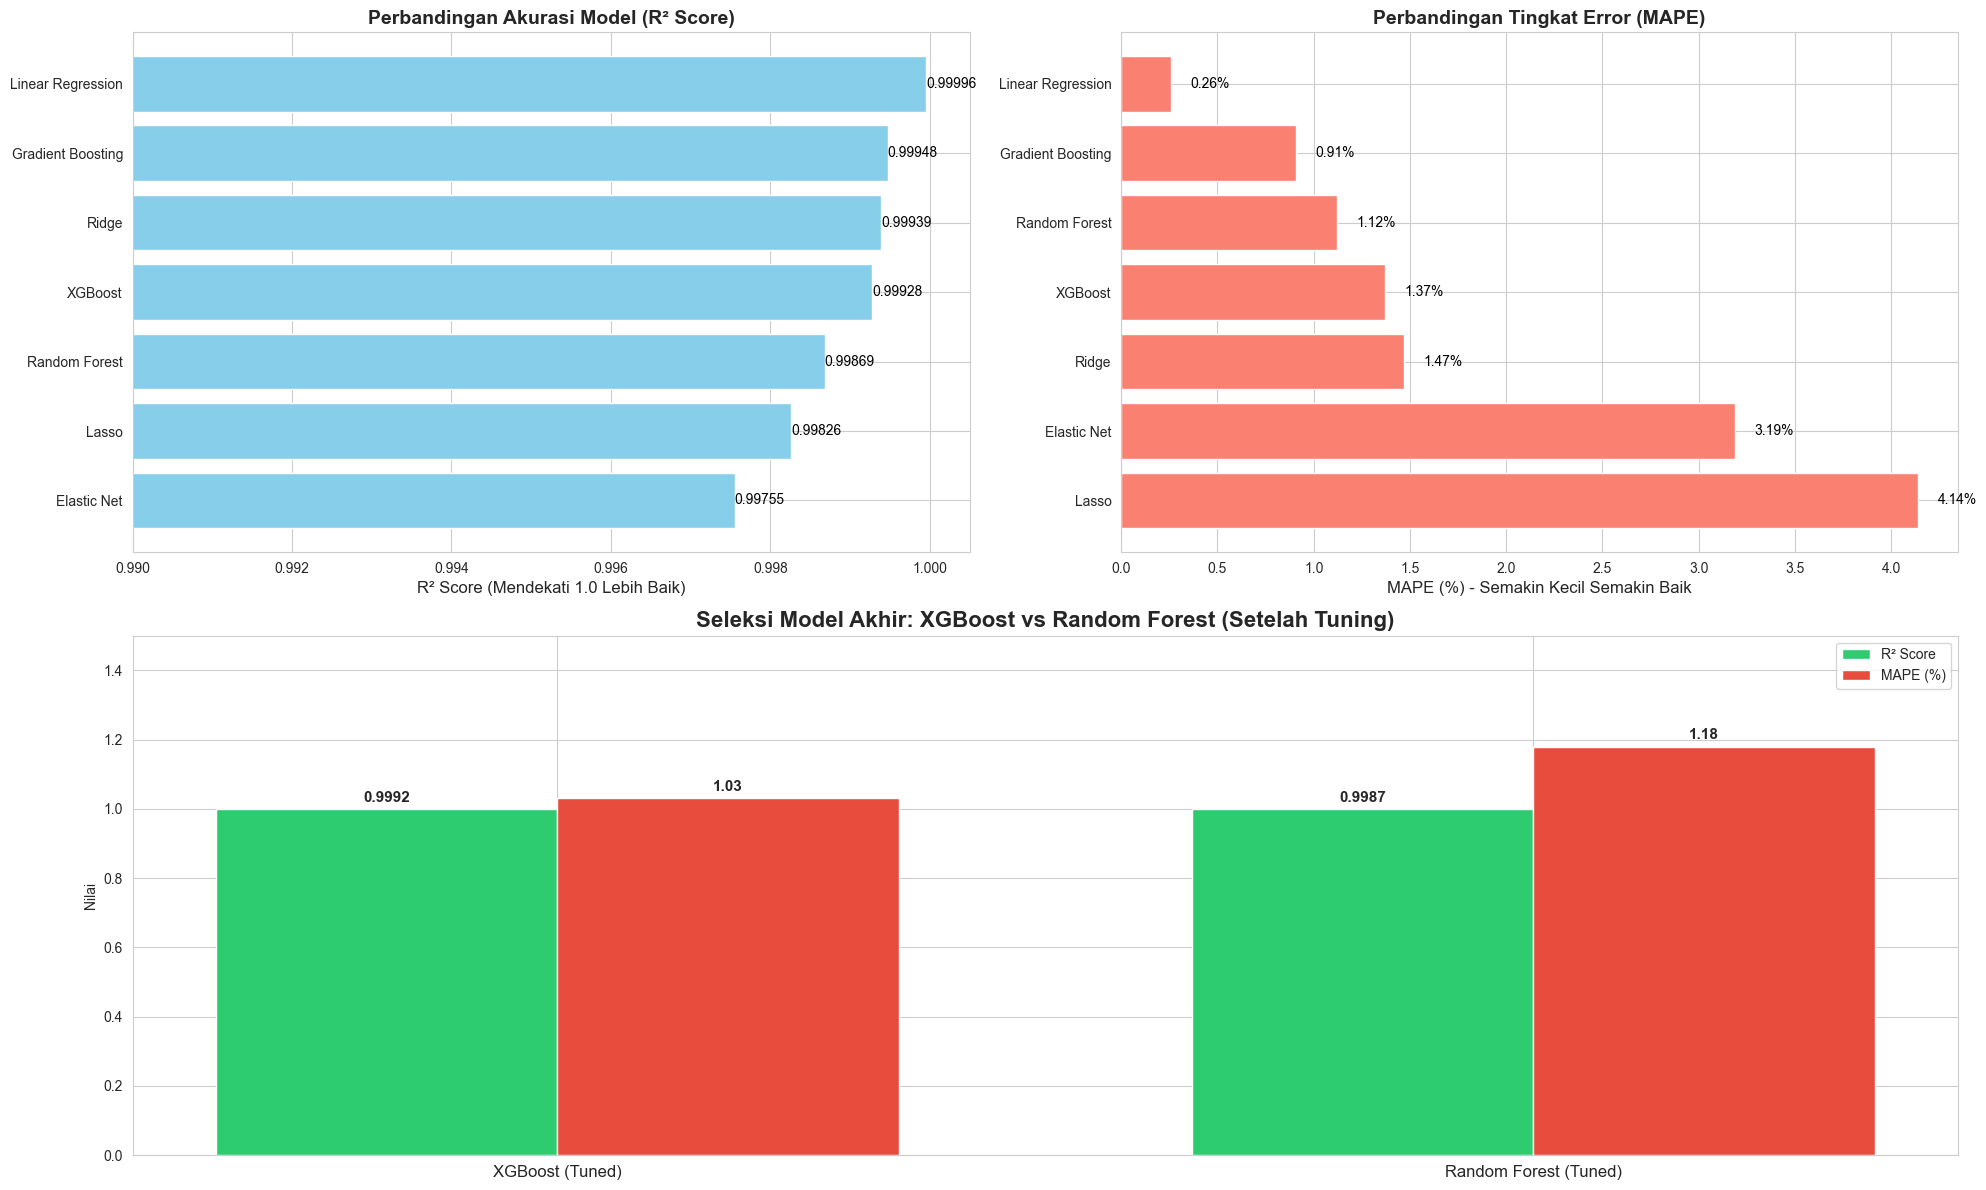

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. SIAPKAN DATA (Berdasarkan hasil training Anda)
# ---------------------------------------------------------
# Data ini diambil dari output log notebook Anda
model_data = {
    'Model': ['Linear Regression', 'Gradient Boosting', 'Ridge', 'XGBoost', 
              'Random Forest', 'Lasso', 'Elastic Net'],
    'R2_Score': [0.999960, 0.999475, 0.999394, 0.999278, 
                 0.998685, 0.998262, 0.997553],
    'MAPE': [0.26, 0.91, 1.47, 1.37, 
             1.12, 4.14, 3.19]
}

df_models = pd.DataFrame(model_data).sort_values('R2_Score', ascending=True)

# Data Model Hasil Tuning (Final Selection)
tuned_data = {
    'Model': ['XGBoost (Tuned)', 'Random Forest (Tuned)'],
    'R2_Score': [0.9992, 0.9987],
    'MAPE': [1.03, 1.18]
}
df_tuned = pd.DataFrame(tuned_data)

# ---------------------------------------------------------
# 2. BUAT VISUALISASI
# ---------------------------------------------------------
plt.figure(figsize=(20, 12))
sns.set_style("whitegrid")

# --- GRAFIK 1: Perbandingan R2 Score (Akurasi) ---
plt.subplot(2, 2, 1)
bars1 = plt.barh(df_models['Model'], df_models['R2_Score'], color='skyblue')
plt.title('Perbandingan Akurasi Model (R² Score)', fontsize=14, fontweight='bold')
plt.xlabel('R² Score (Mendekati 1.0 Lebih Baik)', fontsize=12)
plt.xlim(0.99, 1.0005) # Zoom-in karena nilainya sangat mirip
# Label
for bar in bars1:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.5f}', 
             va='center', ha='left', fontsize=10, color='black')

# --- GRAFIK 2: Perbandingan MAPE (Error) ---
plt.subplot(2, 2, 2)
# Urutkan dari error terkecil ke terbesar untuk visualisasi ini
df_mape = df_models.sort_values('MAPE', ascending=False)
bars2 = plt.barh(df_mape['Model'], df_mape['MAPE'], color='salmon')
plt.title('Perbandingan Tingkat Error (MAPE)', fontsize=14, fontweight='bold')
plt.xlabel('MAPE (%) - Semakin Kecil Semakin Baik', fontsize=12)
# Label
for bar in bars2:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             va='center', ha='left', fontsize=10, color='black')

# --- GRAFIK 3: Final Selection (Tuned Models) ---
plt.subplot(2, 1, 2)
x = np.arange(len(df_tuned['Model']))
width = 0.35

# Plot Grouped Bar Chart
ax = plt.gca()
rects1 = ax.bar(x - width/2, df_tuned['R2_Score'], width, label='R² Score', color='#2ecc71')
rects2 = ax.bar(x + width/2, df_tuned['MAPE'], width, label='MAPE (%)', color='#e74c3c')

ax.set_ylabel('Nilai')
ax.set_title('Seleksi Model Akhir: XGBoost vs Random Forest (Setelah Tuning)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_tuned['Model'], fontsize=12)
ax.set_ylim(0, 1.5)
ax.legend()

# Add labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)



plt.tight_layout()
plt.show()

### analisis fitur penting

In [15]:

print(f"\n{'='*60}")
print("10. ANALISIS PENTINGNYA FITUR")
print("="*60)

if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Fitur Paling Penting:")
    print(feature_importance.head(15).to_string(index=False))
    
    feature_importance.to_csv('05_feature_importance.csv', index=False)
    print("\n✓ Tereskpor: 05_feature_importance.csv")


10. ANALISIS PENTINGNYA FITUR

Top 15 Fitur Paling Penting:
                Feature  Importance
      market_price_mean    0.458740
       market_price_min    0.248984
       market_price_std    0.166652
       market_price_max    0.123874
revenue_per_transaction    0.000474
       price_elasticity    0.000266
            avg_revenue    0.000210
            std_revenue    0.000104
       price_volatility    0.000088
      avg_profit_margin    0.000084
        avg_stock_level    0.000075
   dominant_day_encoded    0.000074
      std_quantity_sold    0.000067
      transaction_count    0.000061
    total_quantity_sold    0.000053

✓ Tereskpor: 05_feature_importance.csv


### penyimpanan model

In [16]:

print(f"\n{'='*60}")
print("11. PENYIMPANAN MODEL (MODEL PERSISTENCE)")
print("="*60)

with open('06_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("✓ Tersimpan: 06_final_model.pkl")

with open('07_feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(" Tersimpan: 07_feature_scaler.pkl")

with open('08_label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print(" Tersimpan: 08_label_encoders.pkl")

with open('09_feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print(" Tersimpan: 09_feature_columns.pkl")

model_metadata = {
    'model_name': final_model_name,
    'model_type': type(final_model).__name__,
    'train_r2': tuned_df.iloc[0]['Train_R2'],
    'val_r2': tuned_df.iloc[0]['Val_R2'],
    'test_r2': test_r2,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_mape': test_mape,
    'n_features': len(feature_columns),
    'training_samples': len(X_train),
    'target_variable': target
}

metadata_df = pd.DataFrame([model_metadata])
metadata_df.to_csv('10_model_metadata.csv', index=False)
print("✓ Tersimpan: 10_model_metadata.csv")



11. PENYIMPANAN MODEL (MODEL PERSISTENCE)
✓ Tersimpan: 06_final_model.pkl
 Tersimpan: 07_feature_scaler.pkl
 Tersimpan: 08_label_encoders.pkl
 Tersimpan: 09_feature_columns.pkl
✓ Tersimpan: 10_model_metadata.csv


### simpulan dan hasil akhir / ringkasan

In [17]:

print(f"\n{'='*60}")
print("RINGKASAN FASE MODELING")
print("="*60)

print(f"\nDataset:")
print(f"  - Total Sampel: {len(X):,}")
print(f"  - Training: {len(X_train):,}")
print(f"  - Validation: {len(X_val):,}")
print(f"  - Test: {len(X_test):,}")
print(f"  - Jumlah Fitur: {len(feature_columns)}")

print(f"\nModel Final: {final_model_name}")
print(f"  - Training R²: {tuned_df.iloc[0]['Train_R2']:.4f}")
print(f"  - Validation R²: {tuned_df.iloc[0]['Val_R2']:.4f}")
print(f"  - Test R²: {test_r2:.4f}")
print(f"  - Test RMSE: {test_rmse:.4f}")
print(f"  - Test MAPE: {test_mape:.2f}%")

print(f"\n{'='*60}")
print("✓ FASE MODELING SELESAI DENGAN SUKSES!")
print("="*60)
print("\nSiap untuk Fase 3: Evaluasi & Deployment")


RINGKASAN FASE MODELING

Dataset:
  - Total Sampel: 497
  - Training: 347
  - Validation: 75
  - Test: 75
  - Jumlah Fitur: 21

Model Final: XGBoost (Tuned)
  - Training R²: 1.0000
  - Validation R²: 0.9993
  - Test R²: 0.9993
  - Test RMSE: 0.0617
  - Test MAPE: 1.49%

✓ FASE MODELING SELESAI DENGAN SUKSES!

Siap untuk Fase 3: Evaluasi & Deployment
